In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import RMSprop
import keras

from sklearn import datasets, model_selection, preprocessing

import numpy as np

import theano
import theano.tensor as T

import scipy
from scipy.fftpack import fft, ifft

import time
from tqdm import tqdm_notebook
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams['font.size']=20

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Comparing numpy and scipy FFT

In [2]:
def numpy_fft(x):
    #numpy doesn't preserve dtype
    return np.fft.fft(np.fft.fft(x)*np.fft.fft(x)).real.astype(np.float32)

def scipy_fft(x):
    #scipy preserves dtype
    return scipy.fftpack.ifft(scipy.fftpack.fft(x)*scipy.fftpack.fft(x)).real

In [3]:
x=np.random.random(size=(1000,1000)).astype(np.float32)

%timeit numpy_fft(x)
%timeit scipy_fft(x)

10 loops, best of 3: 106 ms per loop
10 loops, best of 3: 43.9 ms per loop


## Implementing circulant layer

### Theano forward and gradient operations 

In [4]:
class CirculantConvolutionGradientOp(theano.Op):
    def __init__(self):
        super(CirculantConvolutionGradientOp, self).__init__()

    def make_node(self, r, X, O):
        r = T.as_tensor_variable(r)
        X = T.as_tensor_variable(X)
        O = T.as_tensor_variable(O)

        return theano.Apply(self, [r, X, O], [T.vector(), T.matrix()])

    def perform(self, node, inputs, output_storage):
        
        r = inputs[0]
        X = inputs[1]        
        O = inputs[2]
        
        Offt = fft(O)        

        X_flipped_shifted = np.roll(X[:,::-1],1, axis=1)
        Xfft = fft(X_flipped_shifted)  
        XOfft = np.multiply(Xfft, Offt, out=Xfft) 
        XOfft_sum = np.sum(XOfft, axis=0)
        grad_r = ifft(XOfft_sum).real
        
        Rfft = fft(r)
        ROfft = np.multiply(Rfft, Offt, out=Offt) 
        grad_X = ifft(ROfft).real

        output_storage[0][0] = grad_r
        output_storage[1][0] = grad_X

    def infer_shape(self, node, input_shapes):
        return [input_shapes[0], input_shapes[1]]

In [5]:
class CirculantConvolutionOp(theano.Op):
    def __init__(self):
        super(CirculantConvolutionOp, self).__init__()

    def make_node(self, r, X):
        r = T.as_tensor_variable(r)
        X = T.as_tensor_variable(X)
        
        assert r.ndim == 1
        assert X.ndim == 2
        
        return theano.Apply(self, [r, X], [T.matrix()])

    def perform(self, node, inputs, output_storage):
        r = inputs[0]
        X = inputs[1]
        
        Rfft = fft(r)
        Xfft = fft(X)

        
        RXfft = np.multiply(Rfft, Xfft, out = Xfft)
        
        result = ifft(RXfft).real
        
        output_storage[0][0] = result

    def infer_shape(self, node, input_shapes):
        return [input_shapes[1]]

    def grad(self, inputs, output_grads):
        r = inputs[0]
        X = inputs[1]
        O = output_grads[0]
        
        grad_op = CirculantConvolutionGradientOp()
        return grad_op(r,X, O)

In [6]:
r = T.vector()
X = T.matrix()
conv_op = CirculantConvolutionOp()
f = theano.function([r, X], conv_op(r, X), profile=True)

print(f([1,2], [[1,2],[1,1],[0,0]]))

[[ 5.  4.]
 [ 3.  3.]
 [ 0.  0.]]


In [7]:
T.verify_grad(conv_op,[np.array([1,2], dtype=np.float32), np.array([[10,2],[1,0],[0,0]], dtype=np.float32)],
                         rng=np.random.RandomState(), n_tests=20)

### Implementing linear layer with circulant weights

In [8]:
class CirculantLayer(Layer):

    def __init__(self, output_dim, flip_signs = True, fit_intercept=False, **kwargs):
        self.output_dim = output_dim
        self.fit_intercept = fit_intercept
        self.flip_signs = flip_signs
        super(CirculantLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.flip_signs:
            self.sign_flipping = np.random.randint(0,2, size = input_shape[1])
            self.sign_flipping = (self.sign_flipping*2-1).astype(np.float32)
            self.sign_flipping = K.T.as_tensor_variable(self.sign_flipping)
        
        self.input_dim = input_shape[1]
        
        circulant_vec_shape = (self.input_dim,)
        if self.input_dim<self.output_dim:
            circulant_vec_shape = (self.output_dim,)
        
        self.circulant_vec = self.add_weight(name='circulant_vec', 
                                      shape=circulant_vec_shape,
                                      initializer='uniform',
                                      trainable=True)     
        
        if self.fit_intercept:
            self.bias = self.add_weight(name='bias', 
                                      shape=(self.output_dim,),
                                      initializer='uniform',
                                      trainable=True)
        
        super(CirculantLayer, self).build(input_shape) 

    def call(self, X):
        if self.flip_signs:
            X =  self.sign_flipping * X  
        
        if self.input_dim<self.output_dim:
            zeros = K.T.zeros((X.shape[0], self.output_dim))
            X = K.T.set_subtensor(zeros[:,:self.input_dim], X)
        
        r = self.circulant_vec

        conv_op = CirculantConvolutionOp()
        RX =conv_op(r, X)
        
        if self.input_dim>self.output_dim:
            RX = RX[:, :self.output_dim]
        
        if self.fit_intercept:
            RX = RX + self.bias
        
        return RX

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

## Testing on digits dataset

In [9]:
def model_memory(model):
    return sum(w.nbytes for w in model.get_weights())

In [10]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
le = preprocessing.OneHotEncoder()
y = le.fit_transform(digits.target.reshape(-1, 1)).todense()

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
def fit_circulant_digits():
    model = Sequential()
    model.add(CirculantLayer(1000, input_shape=[X.shape[1]]))
    model.add(Activation('relu'))
    model.add(CirculantLayer(1000))
    model.add(Activation('relu'))
    model.add(CirculantLayer(10))
    model.add(Activation('sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, verbose = 0,epochs=20)
    return model

In [13]:
def fit_dense_digits():
    model = Sequential()
    model.add(Dense(1000, input_shape=[X.shape[1]]))
    model.add(Activation('relu'))
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, verbose=0, epochs=20)
    return model

In [14]:
%timeit -n 10 fit_dense_digits()

10 loops, best of 3: 16.2 s per loop


In [15]:
%timeit -n 10 fit_circulant_digits()

10 loops, best of 3: 7.77 s per loop


In [16]:
circulant_model = fit_circulant_digits()

In [17]:
dense_model = fit_dense_digits()

In [18]:
%timeit dense_model.predict(X_test)

10 loops, best of 3: 34.3 ms per loop


In [19]:
%timeit circulant_model.predict(X_test)

The slowest run took 5.58 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 48 ms per loop


In [20]:
model_memory(dense_model)/model_memory(circulant_model)

358.67

In [21]:
dense_model.evaluate(X_test, y_test)

594/594 [==============================] - ETA:  - ETA:  - 0s 115us/step


[0.072632266745529445, 0.97979797979797978]

In [22]:
circulant_model.evaluate(X_test, y_test)

594/594 [==============================] - ETA:  - ETA:  - 0s 135us/step


[0.085059651847840964, 0.97643097643097643]

## Testing on MNIST dataset

In [23]:
from keras.datasets import mnist

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [25]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [26]:
batch_size = 128
num_classes = 10
epochs = 20

In [27]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [28]:
def get_mnist_model(Layer, dense_layer_size=512):
    model = Sequential()
    model.add(Layer(dense_layer_size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(dense_layer_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(num_classes))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model

def fit_model_mnist(Layer, x_train, y_train, dense_layer_size=512) :
    model = get_mnist_model(Layer, dense_layer_size=dense_layer_size)
    start = time.time()
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,)
    end = time.time()

    print(end - start,'s')
    return model


In [29]:
dense_model = fit_model_mnist(Dense, x_train, y_train)

Epoch 1/20
 - 10s - loss: 0.2445 - acc: 0.9254
Epoch 2/20
 - 9s - loss: 0.1016 - acc: 0.9700
Epoch 3/20
 - 10s - loss: 0.0740 - acc: 0.9782
Epoch 4/20
 - 10s - loss: 0.0591 - acc: 0.9818
Epoch 5/20
 - 10s - loss: 0.0501 - acc: 0.9851
Epoch 6/20
 - 10s - loss: 0.0443 - acc: 0.9868
Epoch 7/20
 - 10s - loss: 0.0393 - acc: 0.9888
Epoch 8/20
 - 10s - loss: 0.0341 - acc: 0.9901
Epoch 9/20
 - 10s - loss: 0.0321 - acc: 0.9907
Epoch 10/20
 - 10s - loss: 0.0277 - acc: 0.9919
Epoch 11/20
 - 11s - loss: 0.0268 - acc: 0.9925
Epoch 12/20
 - 11s - loss: 0.0262 - acc: 0.9928
Epoch 13/20
 - 11s - loss: 0.0245 - acc: 0.9930
Epoch 14/20
 - 12s - loss: 0.0240 - acc: 0.9933
Epoch 15/20
 - 11s - loss: 0.0231 - acc: 0.9940
Epoch 16/20
 - 11s - loss: 0.0213 - acc: 0.9941
Epoch 17/20
 - 11s - loss: 0.0191 - acc: 0.9946
Epoch 18/20
 - 11s - loss: 0.0190 - acc: 0.9947
Epoch 19/20
 - 11s - loss: 0.0184 - acc: 0.9952
Epoch 20/20
 - 11s - loss: 0.0191 - acc: 0.9950
212.08176922798157 s


In [30]:
circulant_model  = fit_model_mnist(CirculantLayer, x_train, y_train)

Epoch 1/20
 - 13s - loss: 1.0348 - acc: 0.6784
Epoch 2/20
 - 13s - loss: 0.6389 - acc: 0.7951
Epoch 3/20
 - 13s - loss: 0.5851 - acc: 0.8140
Epoch 4/20
 - 13s - loss: 0.5630 - acc: 0.8203
Epoch 5/20
 - 13s - loss: 0.5435 - acc: 0.8279
Epoch 6/20
 - 13s - loss: 0.5238 - acc: 0.8340
Epoch 7/20
 - 13s - loss: 0.5205 - acc: 0.8378
Epoch 8/20
 - 13s - loss: 0.5121 - acc: 0.8382
Epoch 9/20
 - 13s - loss: 0.5067 - acc: 0.8399
Epoch 10/20
 - 13s - loss: 0.5037 - acc: 0.8428
Epoch 11/20
 - 13s - loss: 0.5047 - acc: 0.8409
Epoch 12/20
 - 13s - loss: 0.5022 - acc: 0.8414
Epoch 13/20
 - 13s - loss: 0.4966 - acc: 0.8445
Epoch 14/20
 - 13s - loss: 0.5004 - acc: 0.8442
Epoch 15/20
 - 13s - loss: 0.4920 - acc: 0.8471
Epoch 16/20
 - 13s - loss: 0.4878 - acc: 0.8453
Epoch 17/20
 - 13s - loss: 0.4857 - acc: 0.8470
Epoch 18/20
 - 13s - loss: 0.4928 - acc: 0.8452
Epoch 19/20
 - 13s - loss: 0.4891 - acc: 0.8471
Epoch 20/20
 - 13s - loss: 0.4891 - acc: 0.8466
262.9946563243866 s


In [31]:
dense_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 94us/step


[0.11284993469809231, 0.98299999999999998]

In [32]:
circulant_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 129us/step


[0.27687504755854608, 0.92090000000000005]

In [33]:
model_memory(dense_model)/model_memory(circulant_model)

370.41261061946904

In [34]:
def compute_stats(Layer, size):
    start = time.time()
    model = Sequential()
    model.add(Layer(size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(size))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Layer(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=1,
                        verbose=0,)
    end = time.time()

    return end - start, model_memory(model)


In [35]:
layer_sizes= [256, 512, 1024, 2048, 3072]
dense_stats = [compute_stats(Dense, size) for size in tqdm_notebook(layer_sizes)]
circulant_stats = [compute_stats(CirculantLayer, size) for size in tqdm_notebook(layer_sizes)]



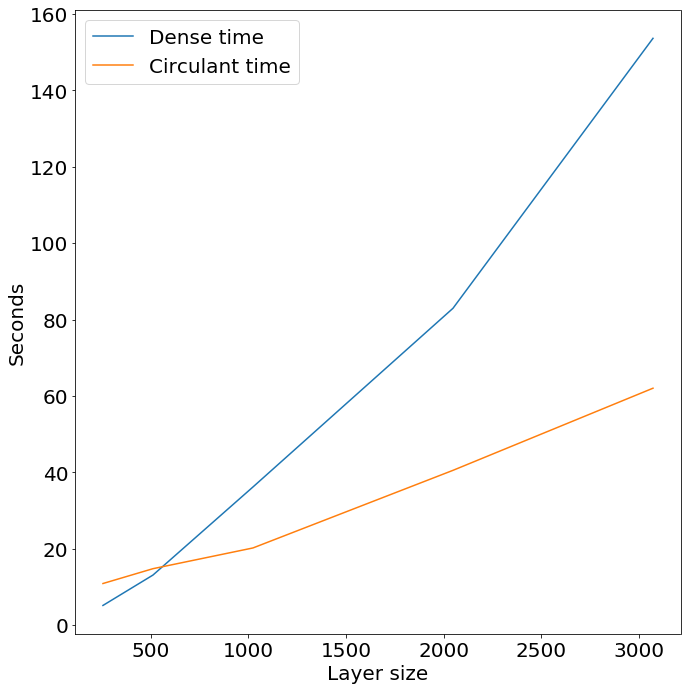

In [36]:
dense_times = list(map(lambda x:x[0], dense_stats))
circulant_times = list(map(lambda x:x[0], circulant_stats))

dense_memory = np.array(list(map(lambda x:x[1], dense_stats)))
circulant_memory = np.array(list(map(lambda x:x[1], circulant_stats)))

plt.plot(layer_sizes, dense_times, label="Dense time")
plt.plot(layer_sizes, circulant_times, label="Circulant time")
plt.xlabel("Layer size")
plt.ylabel("Seconds")
plt.legend()
plt.tight_layout()

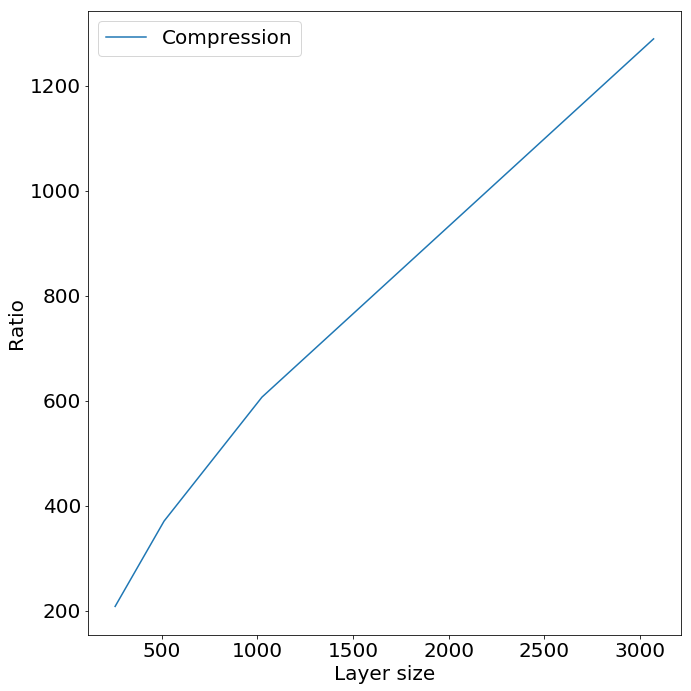

In [37]:
plt.plot(layer_sizes, dense_memory/circulant_memory,  label="Compression")

plt.xlabel("Layer size")
plt.ylabel("Ratio")
plt.legend()
plt.tight_layout()

## Testing on Fashion MNIST dataset

In [38]:
from keras.datasets import fashion_mnist 

In [39]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [40]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [41]:
batch_size = 128
num_classes = 10
epochs = 20

In [42]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [43]:
dense_model = fit_model_mnist(Dense, x_train, y_train)

Epoch 1/20
 - 9s - loss: 0.5614 - acc: 0.7958
Epoch 2/20
 - 9s - loss: 0.4016 - acc: 0.8524
Epoch 3/20
 - 9s - loss: 0.3705 - acc: 0.8653
Epoch 4/20
 - 10s - loss: 0.3486 - acc: 0.8730
Epoch 5/20
 - 10s - loss: 0.3375 - acc: 0.8779
Epoch 6/20
 - 10s - loss: 0.3297 - acc: 0.8814
Epoch 7/20
 - 10s - loss: 0.3201 - acc: 0.8854
Epoch 8/20
 - 10s - loss: 0.3115 - acc: 0.8883
Epoch 9/20
 - 10s - loss: 0.3114 - acc: 0.8890
Epoch 10/20
 - 10s - loss: 0.3072 - acc: 0.8918
Epoch 11/20
 - 10s - loss: 0.3005 - acc: 0.8942
Epoch 12/20
 - 10s - loss: 0.2957 - acc: 0.8963
Epoch 13/20
 - 10s - loss: 0.2914 - acc: 0.8980
Epoch 14/20
 - 10s - loss: 0.2904 - acc: 0.8981
Epoch 15/20
 - 10s - loss: 0.2846 - acc: 0.9004
Epoch 16/20
 - 10s - loss: 0.2822 - acc: 0.9000
Epoch 17/20
 - 11s - loss: 0.2833 - acc: 0.9024
Epoch 18/20
 - 10s - loss: 0.2781 - acc: 0.9037
Epoch 19/20
 - 10s - loss: 0.2711 - acc: 0.9043
Epoch 20/20
 - 10s - loss: 0.2758 - acc: 0.9043
199.43996667861938 s


In [44]:
circulant_model  = fit_model_mnist(CirculantLayer, x_train, y_train)

Epoch 1/20
 - 13s - loss: 1.0608 - acc: 0.6298
Epoch 2/20
 - 13s - loss: 0.7503 - acc: 0.7392
Epoch 3/20
 - 13s - loss: 0.6984 - acc: 0.7574
Epoch 4/20
 - 13s - loss: 0.6712 - acc: 0.7646
Epoch 5/20
 - 13s - loss: 0.6549 - acc: 0.7705
Epoch 6/20
 - 13s - loss: 0.6415 - acc: 0.7741
Epoch 7/20
 - 13s - loss: 0.6303 - acc: 0.7783
Epoch 8/20
 - 13s - loss: 0.6234 - acc: 0.7800
Epoch 9/20
 - 13s - loss: 0.6151 - acc: 0.7823
Epoch 10/20
 - 13s - loss: 0.6126 - acc: 0.7847
Epoch 11/20
 - 13s - loss: 0.6101 - acc: 0.7842
Epoch 12/20
 - 13s - loss: 0.6069 - acc: 0.7848
Epoch 13/20
 - 13s - loss: 0.6071 - acc: 0.7837
Epoch 14/20
 - 13s - loss: 0.5998 - acc: 0.7869
Epoch 15/20
 - 13s - loss: 0.5989 - acc: 0.7880
Epoch 16/20
 - 13s - loss: 0.6007 - acc: 0.7881
Epoch 17/20
 - 13s - loss: 0.5973 - acc: 0.7865
Epoch 18/20
 - 13s - loss: 0.5965 - acc: 0.7887
Epoch 19/20
 - 13s - loss: 0.5958 - acc: 0.7902
Epoch 20/20
 - 14s - loss: 0.5929 - acc: 0.7889
267.6711175441742 s


In [45]:
dense_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 122us/step


[0.38641436491012571, 0.88649999999999995]

In [46]:
circulant_model.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 157us/step


[0.50040812978744509, 0.8236]

In [47]:
model_memory(dense_model)/model_memory(circulant_model)

370.41261061946904

In [48]:
circulant_model_2048  = fit_model_mnist(CirculantLayer, x_train, y_train, dense_layer_size=2048)

Epoch 1/20
 - 40s - loss: 0.8541 - acc: 0.7069
Epoch 2/20
 - 40s - loss: 0.6268 - acc: 0.7811
Epoch 3/20
 - 40s - loss: 0.5766 - acc: 0.7978
Epoch 4/20
 - 41s - loss: 0.5510 - acc: 0.8070
Epoch 5/20
 - 40s - loss: 0.5346 - acc: 0.8105
Epoch 6/20
 - 40s - loss: 0.5245 - acc: 0.8122
Epoch 7/20
 - 40s - loss: 0.5210 - acc: 0.8163
Epoch 8/20
 - 40s - loss: 0.5152 - acc: 0.8170
Epoch 9/20
 - 40s - loss: 0.5082 - acc: 0.8183
Epoch 10/20
 - 40s - loss: 0.4987 - acc: 0.8222
Epoch 11/20
 - 41s - loss: 0.4988 - acc: 0.8214
Epoch 12/20
 - 41s - loss: 0.4968 - acc: 0.8228
Epoch 13/20
 - 40s - loss: 0.4954 - acc: 0.8243
Epoch 14/20
 - 40s - loss: 0.4941 - acc: 0.8235
Epoch 15/20
 - 40s - loss: 0.4924 - acc: 0.8264
Epoch 16/20
 - 40s - loss: 0.4855 - acc: 0.8267
Epoch 17/20
 - 40s - loss: 0.4895 - acc: 0.8254
Epoch 18/20
 - 40s - loss: 0.4883 - acc: 0.8267
Epoch 19/20
 - 40s - loss: 0.4800 - acc: 0.8309
Epoch 20/20
 - 40s - loss: 0.4841 - acc: 0.8289
804.176994562149 s


In [49]:
circulant_model_2048.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 436us/step


[0.42580916891098025, 0.84570000000000001]

In [50]:
model_memory(dense_model)/model_memory(circulant_model_2048)

109.00162760416667

In [51]:
circulant_model_intercept  = fit_model_mnist(partial(CirculantLayer, fit_intercept=True), x_train, y_train)

Epoch 1/20
 - 14s - loss: 1.0172 - acc: 0.6419
Epoch 2/20
 - 14s - loss: 0.6934 - acc: 0.7535
Epoch 3/20
 - 14s - loss: 0.6368 - acc: 0.7715
Epoch 4/20
 - 14s - loss: 0.6092 - acc: 0.7788
Epoch 5/20
 - 14s - loss: 0.5945 - acc: 0.7847
Epoch 6/20
 - 14s - loss: 0.5807 - acc: 0.7908
Epoch 7/20
 - 14s - loss: 0.5742 - acc: 0.7931
Epoch 8/20
 - 14s - loss: 0.5685 - acc: 0.7955
Epoch 9/20
 - 14s - loss: 0.5629 - acc: 0.7973
Epoch 10/20
 - 14s - loss: 0.5604 - acc: 0.7993
Epoch 11/20
 - 14s - loss: 0.5530 - acc: 0.8018
Epoch 12/20
 - 14s - loss: 0.5533 - acc: 0.8023
Epoch 13/20
 - 14s - loss: 0.5487 - acc: 0.8022
Epoch 14/20
 - 14s - loss: 0.5439 - acc: 0.8058
Epoch 15/20
 - 14s - loss: 0.5425 - acc: 0.8056
Epoch 16/20
 - 13s - loss: 0.5397 - acc: 0.8065
Epoch 17/20
 - 14s - loss: 0.5401 - acc: 0.8084
Epoch 18/20
 - 13s - loss: 0.5372 - acc: 0.8075
Epoch 19/20
 - 13s - loss: 0.5318 - acc: 0.8085
Epoch 20/20
 - 13s - loss: 0.5265 - acc: 0.8096
273.993976354599 s


In [52]:
circulant_model_intercept.evaluate(x_test, y_test)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 159us/step


[0.46839489250183103, 0.8286]

In [53]:
model_memory(dense_model)/model_memory(circulant_model_intercept)

235.6460239268121